In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller


df = pd.read_csv("/content/drive/MyDrive/groupeDeTravail-BDAenergie/eco2mix-regional-cons-defcopiecopy.csv", sep=";", low_memory=False)
df.columns
df_idf = df[df['Région'] == 'Île-de-France'].copy()
# Charger le fichier CSV contenant les données, en spécifiant le séparateur et désactivant l'option low_memory
# Remplacer les valeurs manquantes par 0

df['Consommation (MW)'] = df['Consommation (MW)'].fillna(0)
df['Thermique (MW)'] = df['Thermique (MW)'].fillna(0)
df['Nucléaire (MW)'] = df['Nucléaire (MW)'].fillna(0)

# Convertir la colonne de production éolienne en numérique, remplacer les erreurs par NaN puis par
df['Eolien (MW)'] = pd.to_numeric(df['Eolien (MW)'], errors='coerce').fillna(0)
df['Solaire (MW)'] = df['Solaire (MW)'].fillna(0)
df['Hydraulique (MW)'] = df['Hydraulique (MW)'].fillna(0)
df['Pompage (MW)'] = df['Pompage (MW)'].fillna(0)
df['Bioénergies (MW)'] = df['Bioénergies (MW)'].fillna(0)
df = df.drop('Column 30', axis=1)

# Remplacement des valeurs NaN par 0 dans les colonnes TCO
colonnes_tco = ["TCO Thermique (%)", "TCO Nucléaire (%)", "TCO Eolien (%)",
                "TCO Hydraulique (%)", "TCO Solaire (%)", "TCO Bioénergies (%)"]
df[colonnes_tco] = df[colonnes_tco].fillna(0)



# Garder uniquement les lignes où au moins une valeur TCO est non nulle
df = df[(df[colonnes_tco] != 0).any(axis=1)]

# Remplacement des valeurs NaN par 0 dans les colonnes TCH
colonnes_tch = ["TCH Thermique (%)", "TCH Nucléaire (%)", "TCH Eolien (%)",
                "TCH Hydraulique (%)", "TCH Solaire (%)", "TCH Bioénergies (%)"]
df[colonnes_tch] = df[colonnes_tch].fillna(0)


# Garder uniquement les lignes où au moins une valeur TCH est non nulle
df = df[(df[colonnes_tch] != 0).any(axis=1)]

# Regrouper les données par région et calculer la consommation totale d'électricité pour chaque région
consumption_by_region = df.groupby('Région')['Consommation (MW)'].sum().sort_values(ascending=False)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-5-47c3009d935d>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[colonnes_tch] = df[colonnes_tch].fillna(0)


,Code INSEE région,Région,Nature,Date,Heure,Date - Heure,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),...,TCO Nucléaire (%),TCH Nucléaire (%),TCO Eolien (%),TCH Eolien (%),TCO Solaire (%),TCH Solaire (%),TCO Hydraulique (%),TCH Hydraulique (%),TCO Bioénergies (%),TCH Bioénergies (%)
1472256,24,Centre-Val de Loire,Données définitives,2020-01-01,00:00,2019-12-31T23:00:00+00:00,2965.0,105.0,8013.0,18.0,...,270.25,68.90,0.61,1.42,0.0,0.0,1.65,52.69,2.09,48.44
1472257,11,Île-de-France,Données définitives,2020-01-01,00:00,2019-12-31T23:00:00+00:00,10462.0,326.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,1.28,39.88
1472258,27,Bourgogne-Franche-Comté,Données définitives,2020-01-01,00:00,2019-12-31T23:00:00+00:00,2737.0,181.0,0.0,247.0,...,0.00,0.00,9.02,30.12,0.0,0.0,4.53,23.62,1.75,50.00
1472259,52,Pays de la Loire,Données définitives,2020-01-01,00:00,2019-12-31T23:00:00+00:00,4078.0,359.0,0.0,135.0,...,0.00,0.00,3.31,13.34,0.0,0.0,0.12,50.00,1.32,47.79
1472260,32,Hauts-de-France,Données définitives,2020-01-01,00:00,2019-12-31T23:00:00+00:00,6582.0,2030.0,4507.0,1575.0,...,68.47,82.55,23.93,34.19,0.0,0.0,0.03,50.00,1.81,51.97


Valeurs manquantes dans 'Consommation (MW)' remplies par 0.
Colonne 'Date' convertie en type datetime et définie comme index.
Filtrage effectué pour la région : Île-de-France. Le nombre de lignes après filtrage est : 176784.
Test de Dickey-Fuller:
Statistic: -10.174978924227549
p-value: 6.930458345063207e-18
Les données sont stationnaires.
Doublons supprimés dans l'index. Le nombre de lignes après suppression est : 3683.
Différenciation appliquée pour stationnariser les données.
Modèle SARIMA créé.


<ipython-input-10-020b5d13809b>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff'] = df['Consommation (MW)'].diff().dropna()
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Modèle ajusté.
                                     SARIMAX Results                                      
Dep. Variable:                  Consommation (MW)   No. Observations:                 3683
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -26571.292
Date:                            Wed, 27 Nov 2024   AIC                          53152.584
Time:                                    18:32:51   BIC                          53183.605
Sample:                                01-01-2013   HQIC                         53163.631
                                     - 01-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0310      0.055     -0.562      0.574      -0.139       0.077
ma.L1          0.205

<ipython-input-10-020b5d13809b>:54: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=df.index[-1], periods=forecast_period + 1, freq='M')[1:]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


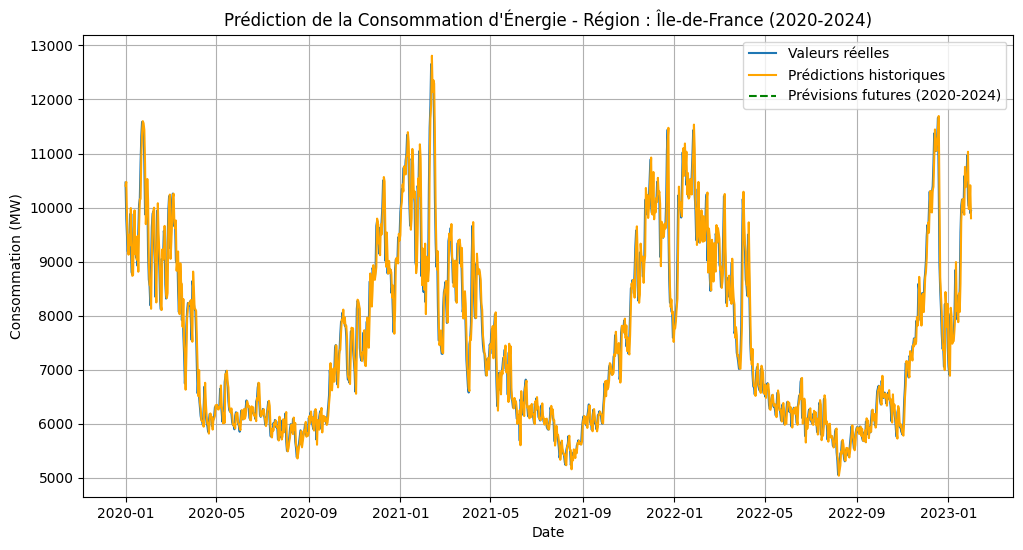

Graphique des prévisions zoomé sur 2020-2024 affiché.


In [ ]:
# Remplissage des valeurs manquantes
df['Consommation (MW)'] = df['Consommation (MW)'].fillna(0)
print("Valeurs manquantes dans 'Consommation (MW)' remplies par 0.")

# Conversion de la colonne 'Date' en type datetime et définir comme index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
print("Colonne 'Date' convertie en type datetime et définie comme index.")

# Filtrer pour garder une seule région (Île-de-France)
region = 'Île-de-France'
df = df[df['Région'] == region]
print(f"Filtrage effectué pour la région : {region}. Le nombre de lignes après filtrage est : {df.shape[0]}.")

# Vérification de la stationnarité avec le test de Dickey-Fuller
result = adfuller(df['Consommation (MW)'])
print('Test de Dickey-Fuller:')
print(f'Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    print("Les données ne sont pas stationnaires. Une différenciation peut être nécessaire.")
else:
    print("Les données sont stationnaires.")

# Gérer les doublons dans l'index (si des dates répétées existent)
df = df[~df.index.duplicated(keep='first')]
print(f"Doublons supprimés dans l'index. Le nombre de lignes après suppression est : {df.shape[0]}.")

# Différenciation si nécessaire (pour stationnariser la série)
df['diff'] = df['Consommation (MW)'].diff().dropna()
print("Différenciation appliquée pour stationnariser les données.")

# Utilisation d'un modèle SARIMA pour la modélisation
model = SARIMAX(df['Consommation (MW)'],
                order=(1, 1, 1),  # Paramètres ARIMA (p, d, q)
                seasonal_order=(1, 1, 1, 12),  # Paramètres saisonniers (P, D, Q, s)
                enforce_stationarity=False,
                enforce_invertibility=False)
print("Modèle SARIMA créé.")

# Ajustement du modèle
results = model.fit()
print("Modèle ajusté.")
print(results.summary())

# Predictions sur les données existantes
df['prediction'] = results.predict(start=df.index.min(), end=df.index.max())
print("Predictions générées sur les données historiques.")

# Predictions pour les 3 prochaines années (36 mois)
forecast_period = 36  # 3 ans
forecast = results.get_forecast(steps=forecast_period)
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_period + 1, freq='M')[1:]

# Ajouter les prévisions futures au DataFrame
forecast_values = forecast.predicted_mean
df_forecast = pd.DataFrame(forecast_values, index=forecast_index, columns=['forecast'])

# Filtrer les données pour la période 2020-2024
df_zoom = df['2020-01-01':'2024-12-31']
df_forecast_zoom = df_forecast['2020-01-01':'2024-12-31']

# Calcul du RMSE et du R² pour l'évaluation du modèle
rmse = mean_squared_error(df['Consommation (MW)'], df['prediction'], squared=False)
r2 = r2_score(df['Consommation (MW)'], df['prediction'])
print(f"RMSE des prédictions historiques : {rmse}")
print(f"R² des prédictions historiques : {r2}")

# Graphique des prédictions et des valeurs réelles zoomées
plt.figure(figsize=(12, 6))
plt.plot(df_zoom.index, df_zoom['Consommation (MW)'], label='Valeurs réelles')
plt.plot(df_zoom.index, df_zoom['prediction'], label='Predictions historiques', color='orange')
plt.plot(df_forecast_zoom.index, df_forecast_zoom['forecast'], label='Prévisions futures (2020-2024)', color='green', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Consommation (MW)')
plt.title(f'Prédiction de la Consommation d\'Énergie - Région : {region} (2020-2024)')
plt.legend()
plt.grid(True)
plt.show()
print("Graphique des prévisions zoomé sur 2020-2024 affiché.")

Taille des données après suppression des NaN pour Île-de-France: (36527, 35)
Mean Squared Error (MSE): 25074.35162164766
Root Mean Squared Error (RMSE): 158.34882892414348
R² Score: 0.9758601276866943
Coefficients du modèle: [[2076.57319123    6.38967334]
 [   7.6790723   264.47303759]]


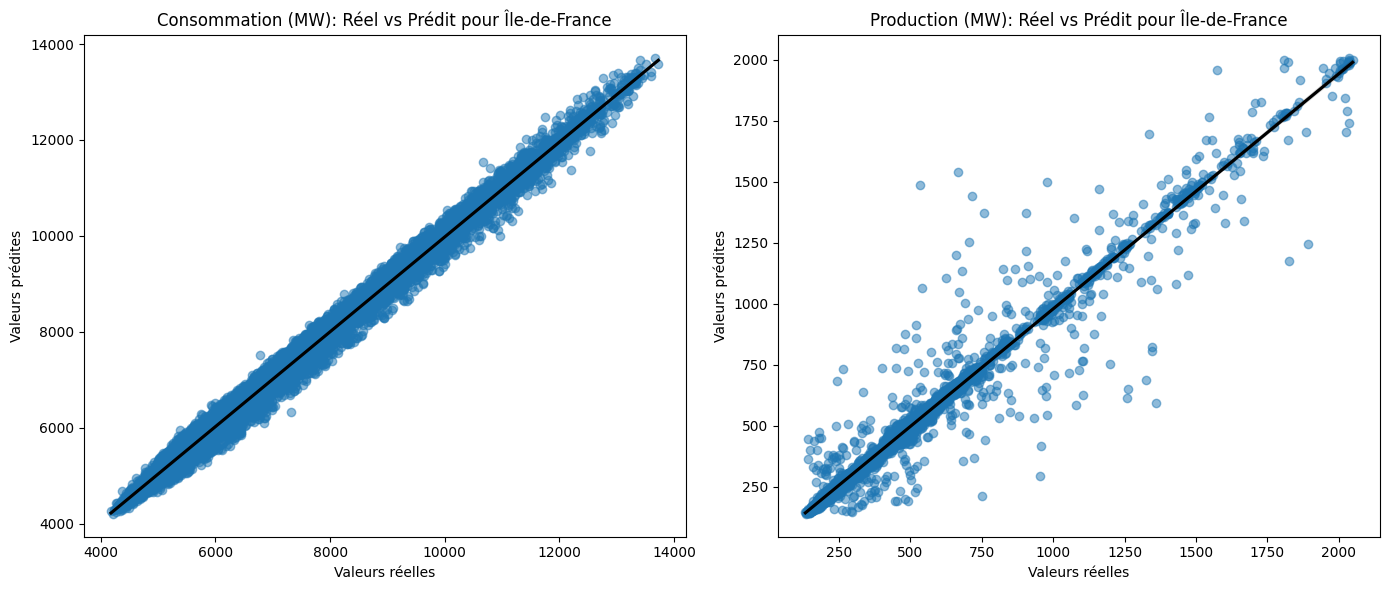

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Chargement des données
df = pd.read_csv(
    "/content/drive/MyDrive/groupeDeTravail-BDAenergie/eco2mix-regional-cons-defcopiecopy.csv",
    sep=";",
    low_memory=False
)

# Vérification que toutes les colonnes nécessaires existent
required_columns = [
    'Thermique (MW)', 'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)',
    'Hydraulique (MW)', 'Pompage (MW)', 'Bioénergies (MW)', 'Consommation (MW)', 'Région'
]
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"Colonnes manquantes: {missing_columns}")

# Filtrage pour "Île-de-France"
df_idf = df[df['Région'] == 'Île-de-France'].copy()

# Conversion des valeurs d'éolien en numériques
df_idf['Eolien (MW)'] = pd.to_numeric(df_idf['Eolien (MW)'], errors='coerce')

# Gestion des valeurs manquantes
df_idf['Eolien (MW)'] = df_idf['Eolien (MW)'].ffill().fillna(0)

# Calcul de la production totale d'électricité
df_idf['Production (MW)'] = (
    df_idf['Thermique (MW)'] +
    df_idf['Nucléaire (MW)'] +
    df_idf['Eolien (MW)'] +
    df_idf['Solaire (MW)'] +
    df_idf['Hydraulique (MW)'] +
    df_idf['Pompage (MW)'] +
    df_idf['Bioénergies (MW)']
)

# Création des caractéristiques (features)
df_idf['Consommation_N-1'] = df_idf['Consommation (MW)'].shift(1)
df_idf['Production_N-1'] = df_idf['Production (MW)'].shift(1)

# Suppression des lignes contenant des NaN
df_idf = df_idf.dropna(subset=['Consommation_N-1', 'Production_N-1', 'Consommation (MW)', 'Production (MW)'])

# Vérification des dimensions
print(f"Taille des données après suppression des NaN pour Île-de-France: {df_idf.shape}")

# Variables X et y
X = df_idf[['Consommation_N-1', 'Production_N-1']]
y = df_idf[['Consommation (MW)', 'Production (MW)']]

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Découpage en ensembles d'entraînement et de test
train_size = int(0.8 * len(df_idf))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Regression Model linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

# Coefficients du modèle
print(f"Coefficients du modèle: {model.coef_}")

# Graphiques des valeurs réelles vs prédites
plt.figure(figsize=(14, 6))

# Consommation (MW)
plt.subplot(1, 2, 1)
sns.regplot(x=y_test['Consommation (MW)'], y=y_pred[:, 0], scatter_kws={'alpha': 0.5}, line_kws={'color': 'black'})
plt.title('Consommation (MW): Réel vs Prédit pour Île-de-France')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')

# Production (MW)
plt.subplot(1, 2, 2)
sns.regplot(x=y_test['Production (MW)'], y=y_pred[:, 1], scatter_kws={'alpha': 0.5}, line_kws={'color': 'black'})
plt.title('Production (MW): Réel vs Prédit pour Île-de-France')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')

plt.tight_layout()
plt.show()

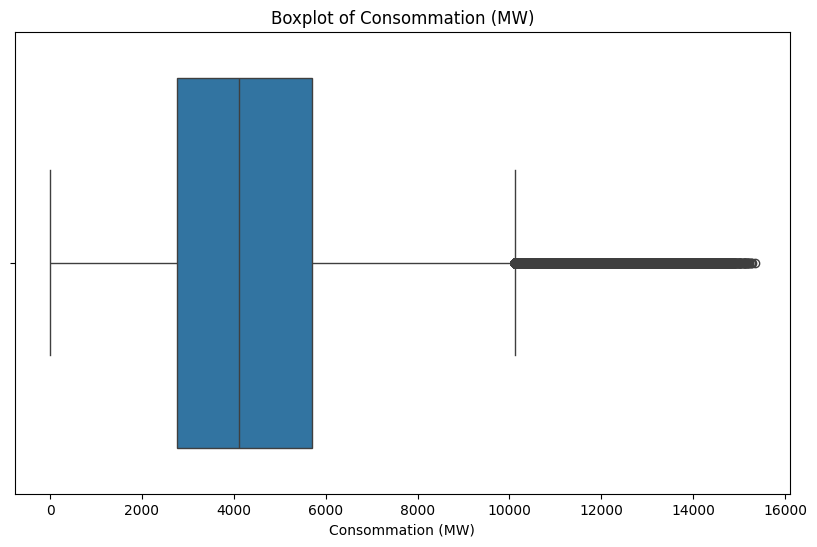

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Linear Regression:
  RMSE: 600.6499372717811
  MSE: 360780.34714459465
  MAE: 420.36091352673685
  R²: 0.9362940823874375
--------------------------------------------------


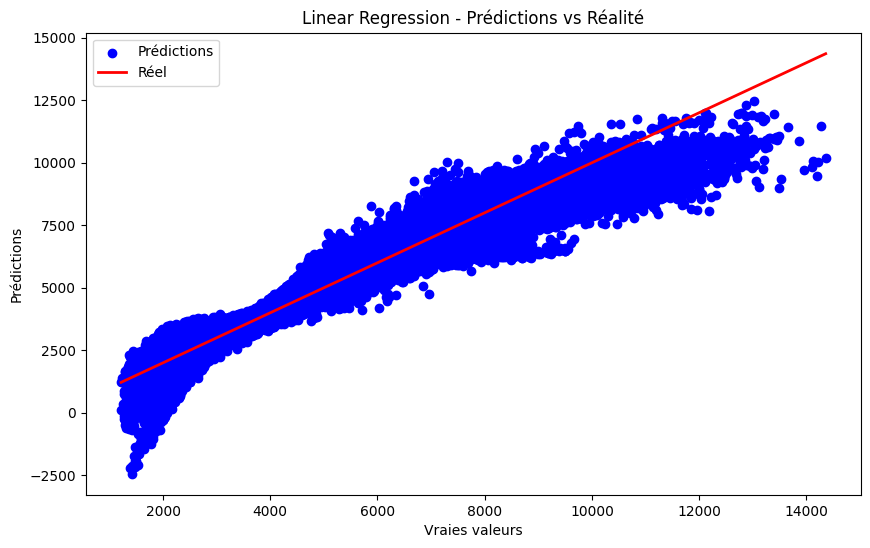

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Decision Tree Regressor:
  RMSE: 31.9424679709427
  MSE: 1020.3212600747003
  MAE: 13.883158049931197
  R²: 0.9998198335839324
--------------------------------------------------


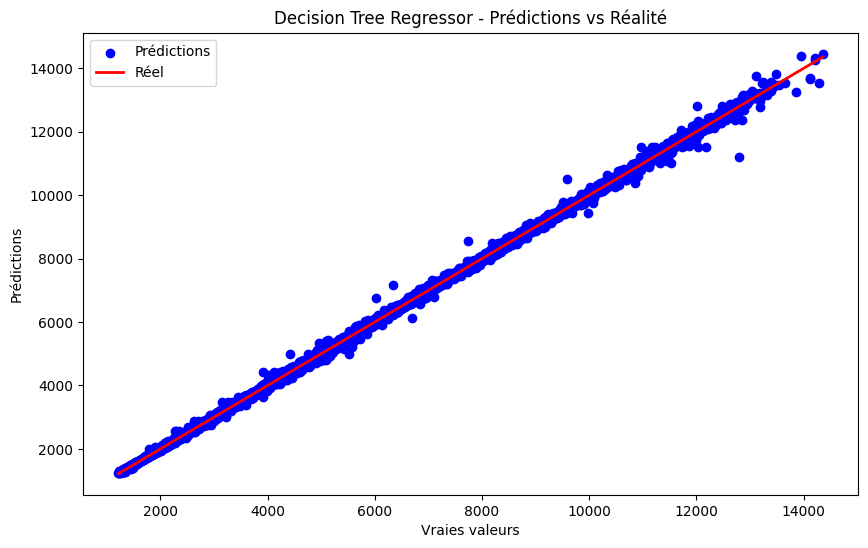

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest Regressor:
  RMSE: 20.153169067020524
  MSE: 406.15022344391286
  MAE: 8.784292799339118
  R²: 0.9999282827546516
--------------------------------------------------


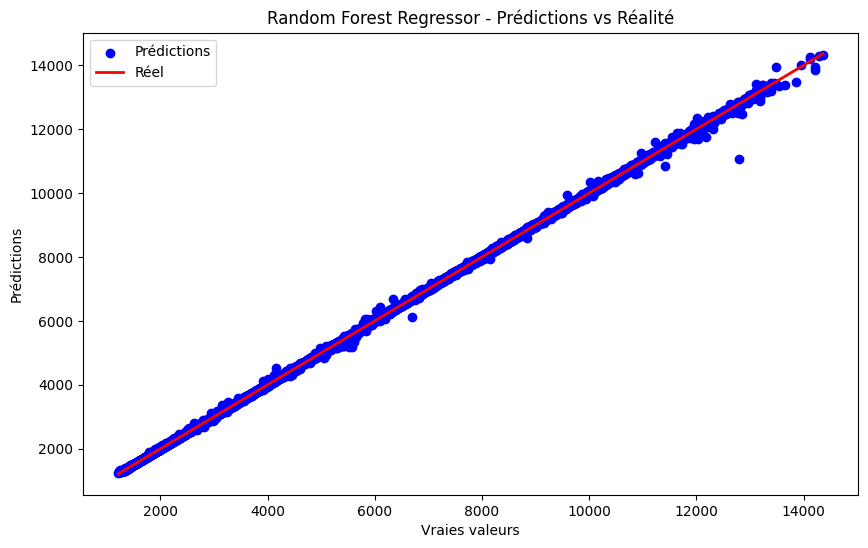

Informations sur le DataFrame nettoyé :
<class 'pandas.core.frame.DataFrame'>
Index: 508608 entries, 1472260 to 2121407
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Code INSEE région    508608 non-null  int64  
 1   Région               508608 non-null  object 
 2   Nature               508608 non-null  object 
 3   Date                 508608 non-null  object 
 4   Heure                508608 non-null  object 
 5   Date - Heure         508608 non-null  object 
 6   Consommation (MW)    508608 non-null  float64
 7   Thermique (MW)       508608 non-null  float64
 8   Nucléaire (MW)       508608 non-null  float64
 9   Eolien (MW)          508608 non-null  float64
 10  Solaire (MW)         508608 non-null  float64
 11  Hydraulique (MW)     508608 non-null  float64
 12  Pompage (MW)         508608 non-null  float64
 13  Bioénergies (MW)     508608 non-null  float64
 14  Ech. physiques (MW)  50860

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Performances du modèle :
RMSE: 509.3959461535592
R²: 0.9394053436353372


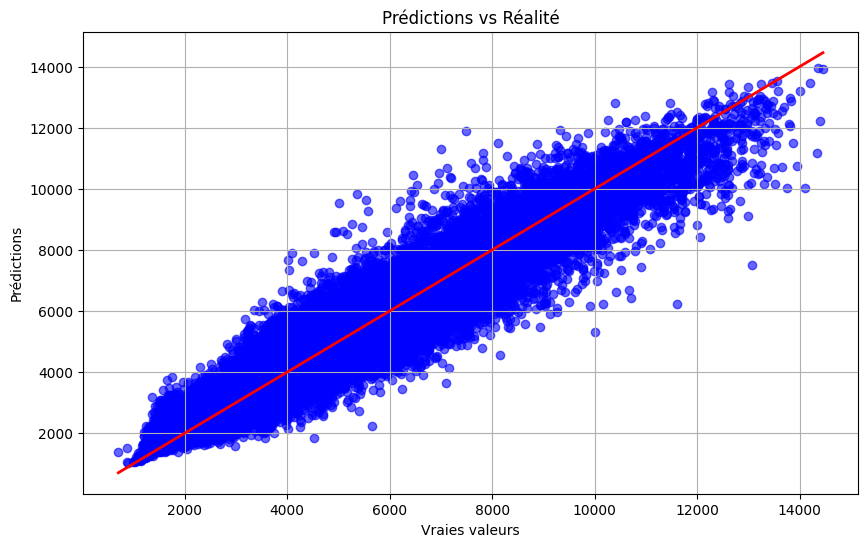

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Charger le fichier CSV
file_path = "/content/drive/MyDrive/groupeDeTravail-BDAenergie/eco2mix-regional-cons-defcopiecopy.csv"
df = pd.read_csv(file_path, sep=";", low_memory=False)

# Remplacer les valeurs 'ND' par NaN pour un nettoyage plus facile
df.replace('ND', np.nan, inplace=True)

# Convertir les colonnes pertinentes en type numérique
columns_to_convert = [
    'Thermique (MW)', 'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)',
    'Hydraulique (MW)', 'Pompage (MW)', 'Bioénergies (MW)', 'TCO Thermique (%)',
    'TCO Nucléaire (%)', 'TCO Eolien (%)', 'TCO Hydraulique (%)',
    'TCO Solaire (%)', 'TCO Bioénergies (%)', 'Consommation (MW)'
]
for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Supprimer les lignes avec des valeurs manquantes dans les colonnes choisies
df_cleaned = df.dropna(subset=columns_to_convert)

# Vérifier le contenu du DataFrame nettoyé
print("Informations sur le DataFrame nettoyé :")
print(df_cleaned.info())

# Si le DataFrame est vide, signaler le problème
if df_cleaned.empty:
    print("Le DataFrame nettoyé est vide. Vérifiez vos données source.")
else:
    print(f"Le DataFrame nettoyé contient {len(df_cleaned)} lignes.")

# Sélectionner X (caractéristiques) et y (cible)
X = df_cleaned[['Thermique (MW)', 'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)',
                'Hydraulique (MW)', 'Pompage (MW)', 'Bioénergies (MW)', 'TCO Thermique (%)',
                'TCO Nucléaire (%)', 'TCO Eolien (%)', 'TCO Hydraulique (%)',
                'TCO Solaire (%)', 'TCO Bioénergies (%)']]
y = df_cleaned['Consommation (MW)']

# Division des données en ensembles d'entraînement et de test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création et entraînement du modèle des k plus proches voisins (régression)
model = KNeighborsRegressor(n_neighbors=7, metric='minkowski')
model.fit(X_train, y_train)

# Predictions sur les données de test
y_pred = model.predict(X_test)

# Calcul des performances du modèle
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'\nPerformances du modèle :')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

# Visualization of results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('Vraies valeurs')
plt.ylabel('Predictions')
plt.title('Predictions vs Réalité')
plt.grid()
plt.show()